<a href="https://colab.research.google.com/github/olya-ds/ml-course-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовой проект

**Дисциплина:** Дополнительные разделы машинного обучения

**Выполнила:** Медведева Ольга

**Группа:** S41012

**Набор данных:** Bank Marketing Dataset | https://www.kaggle.com/datasets/hariharanpavan/bank-marketing-dataset-analysis-classification

**Источник:**
[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 

  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

**Задача:** Выявить признаки, которые влияют на успех маркетинговой кампании банка, в частности, на оформление срочного депозита и спрогнозировать поведение потенциального клиента.

In [1]:
# импортирую библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## 1. Оценка набора данных

In [2]:
# читаю данные

df = pd.read_csv('https://raw.githubusercontent.com/olya-ds/ml-course-project/main/data/bank-full.csv')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Данные состоят из 45211 объектов, каждый их которых обладает 16 признаками и значением 1 целевой переменной.

**Предикторы:**

Данные клиента банка:

X0 age - возраст (numeric)

X1 job - тип работы (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 

X2 marital - семейное положение (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

X3 education - образование (categorical: "unknown","secondary","primary","tertiary")

X4 default - дефолт по кредиту (binary: "yes","no")

X5 balance - среднегодовой баланс в евро (numeric) 

X6 housing - наличие жилищного кредита (binary: "yes","no")

X7 loan - наличие личного кредита (binary: "yes","no")

Данные о последнем контакте текущей кампании:

X8 contact - тип контактной связи (categorical: "unknown","telephone","cellular") 

X9 day - последний контактный день месяца (numeric)

X10 month - последний месяц контакта в году (categorical: "jan", "feb", "mar", ..., "nov", "dec")

X11 duration - продолжительность последнего контакта в секундах (numeric)

Другие переменные:

X12 campaign - количество контактов, выполненных во время этой кампании и для этого клиента (numeric, includes last contact)

X13 pdays - количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании (numeric, -1 means client was not previously contacted)

X14 previous - количество контактов, выполненных до этой кампании и для этого клиента (numeric)

X15 poutcome - результат предыдущей маркетинговой кампании (categorical: "unknown","other","failure","success")


**Отклики:**

y - оформил ли клиент срочный депозит? (binary: "yes","no")

In [4]:
# посчитаю число уникальных значений в столбцах

for column in df.columns:
    print(column,df[column].nunique())

age 77
job 12
marital 3
education 4
default 2
balance 7168
housing 2
loan 2
contact 3
day 31
month 12
duration 1573
campaign 48
pdays 559
previous 41
poutcome 4
y 2


In [5]:
# проверю наличие пропусков в столбцах

df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.duplicated().sum()

0

**Вывод:** При оценке количественных характеристик данных выяснилось что в данных отсутствуют пропуски, дубликаты и признаки с одним уникальным значением (их можно было бы удалить, так как они не влияют на результат).

## 2. Описательный анализ данных

### 2.1 Числовые признаки

In [7]:
# посмотрю статистику числовых столбцов

df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Можно увидеть, что, например, признак "balance" имеет высокие отрицательные и положительные значения суммы на счету. В столбце "campaign" до 75% всех значений не превышает 3, но максимальное число контактов с клиентом равно – 63. В столбце "pdays" 75% значений "-1", но максимальное – 871, что значит, что с 75% клиентов не было прошлого контакта. В столбце "previous" большая часть значений – 0, так как предыдущих контактов с этим клиентом не было.

In [8]:
# функция для формирования массива данных, в которые не входят данные превышающие 1.5-ый интервал между верхним и нижним квантилями

def cut_tails(array):
    array_cut = []
    q75, q25 = np.percentile(array, [75, 25])
    interval = q75 - q25
    
    min_dist = q25 - (1.5 * interval)
    max_dist = q75 + (1.5 * interval)
    
    for data in array:
        if data < max_dist and data > min_dist:
            array_cut.append(data)
    return array_cut

In [9]:
# выделю числовые признаки

num_features=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

**Замечание:** Особые значения имеет столбец "pdays", в которм при отсутствии контакта с клиентом параметр принимает значение "-1". Также столбец "previous" часто принимает значение "0" из-за отсутствия контакотов. Для этих столбцов ограничю значения.

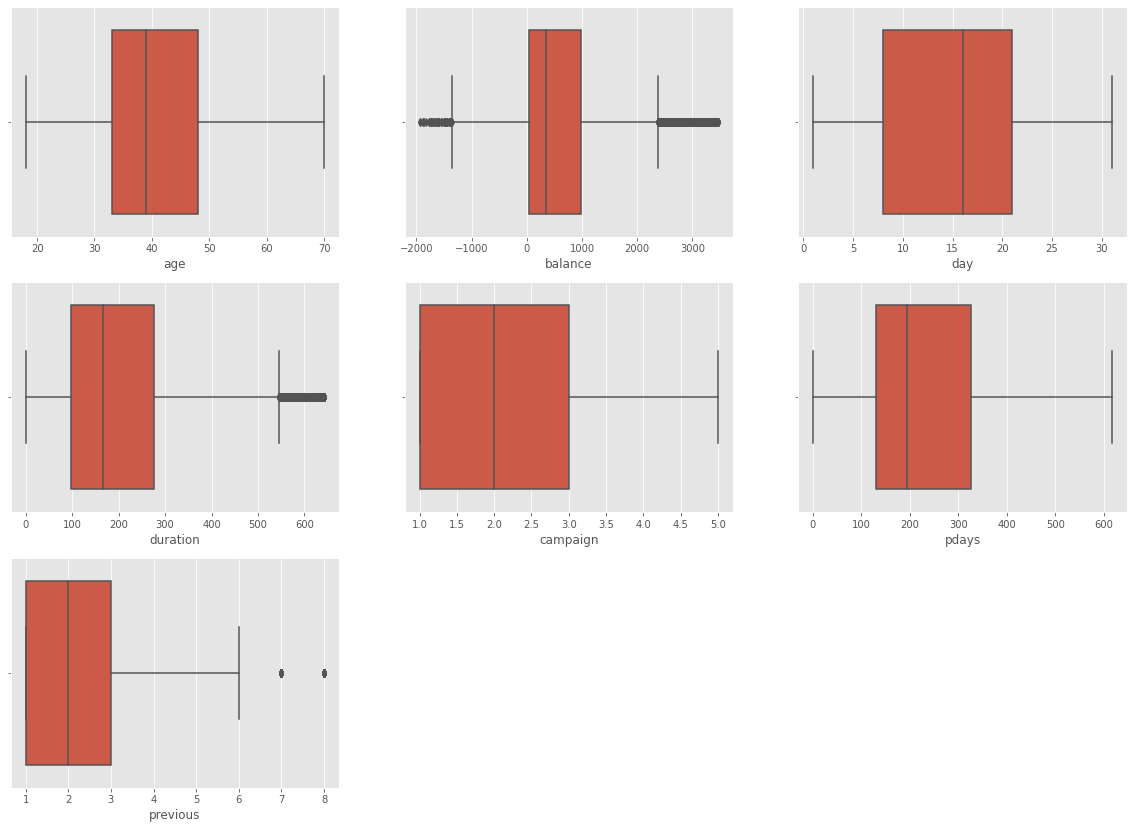

In [10]:
# построю boxplot для числовых признаков

plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for feature in num_features:
    ax = plt.subplot(12,3,plotnumber)
    
    if feature in ['pdays', 'previous']:
        sns.boxplot(cut_tails(df[(df[feature] != -1) & (df[feature] != 0)][feature]))
    else:
        sns.boxplot(cut_tails(df[feature]))
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

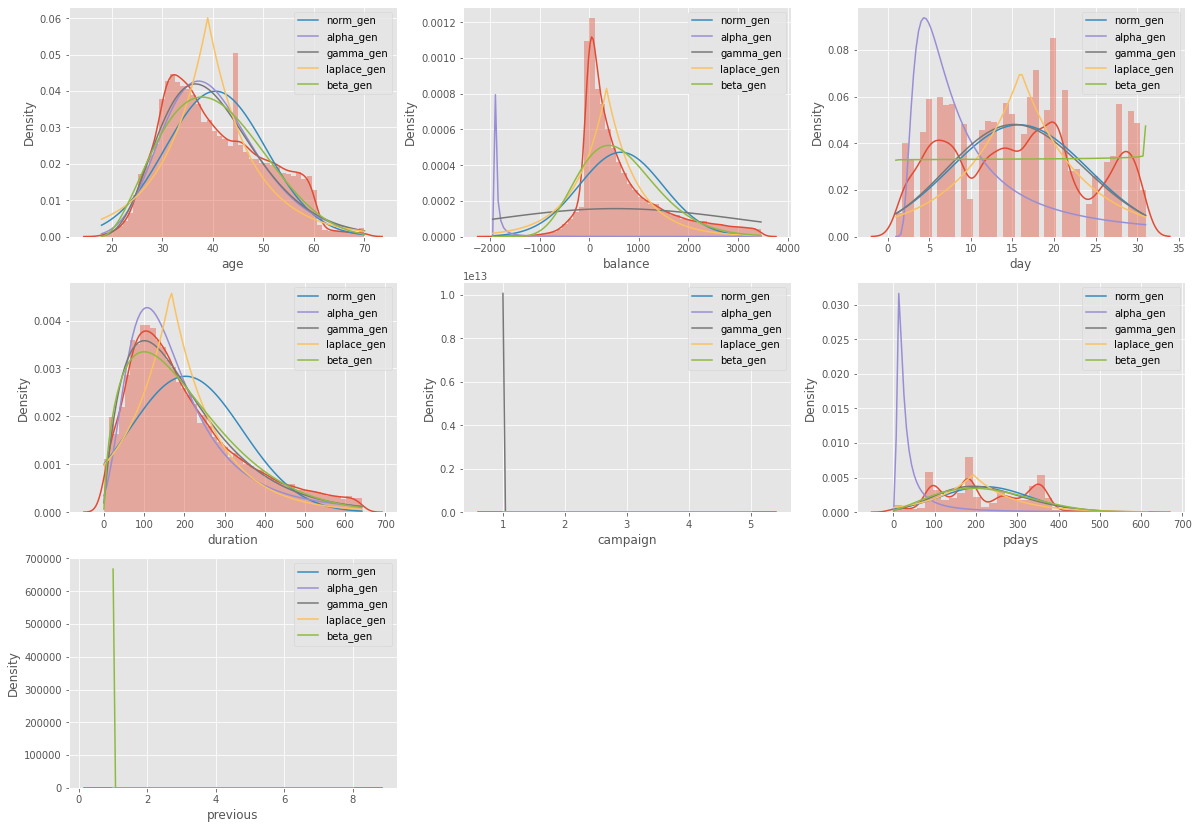

In [11]:
# построю графики плотности распределения числовых переменных 

plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for feature in num_features:
    ax = plt.subplot(12,3,plotnumber)
    
    if feature in ['pdays', 'previous']:
        array = cut_tails(df[(df[feature] != -1) & (df[feature] != 0)][feature])
        sns.distplot(array)
    
    else:
        array = cut_tails(df[feature])
        subplot = sns.distplot(array)
    for distribution in ([scipy.stats.norm, scipy.stats.alpha, scipy.stats.gamma,
                          scipy.stats.laplace, scipy.stats.beta]):
        x_plot = np.linspace(np.min(array), np.max(array), 100)
        args = distribution.fit(array)
        y_plot = distribution.pdf(x_plot, *args)
        sns.lineplot(x_plot, y_plot, label=type(distribution).__name__)
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

**Вывод:** 
- Признаки "balance"(баланс на счету) и "duration"(продолжительность последнего контакта в секундах) имеют много значений вне boxplotа, так как это те признаки, которые имеют большой диапозон возможных значений.
- Числовые переменные 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous' имеют gamma-рапсределение, распределение Лапласа, нормальное рапредление, gamma-рапсределение, gamma-рапсределение, нормальное рапредление, beta-рапределение, соответственно.
- При грубой оценке можно сказать о том, что все числовые признаки имеют нормальное рапсределение, но либо смещенное влево, либо сочетающее в себеб несколько нормальных рапредлений.

### 2.2 Категориальные признаки

In [12]:
# выделю категориальные и бинарные признаки

cat_features=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

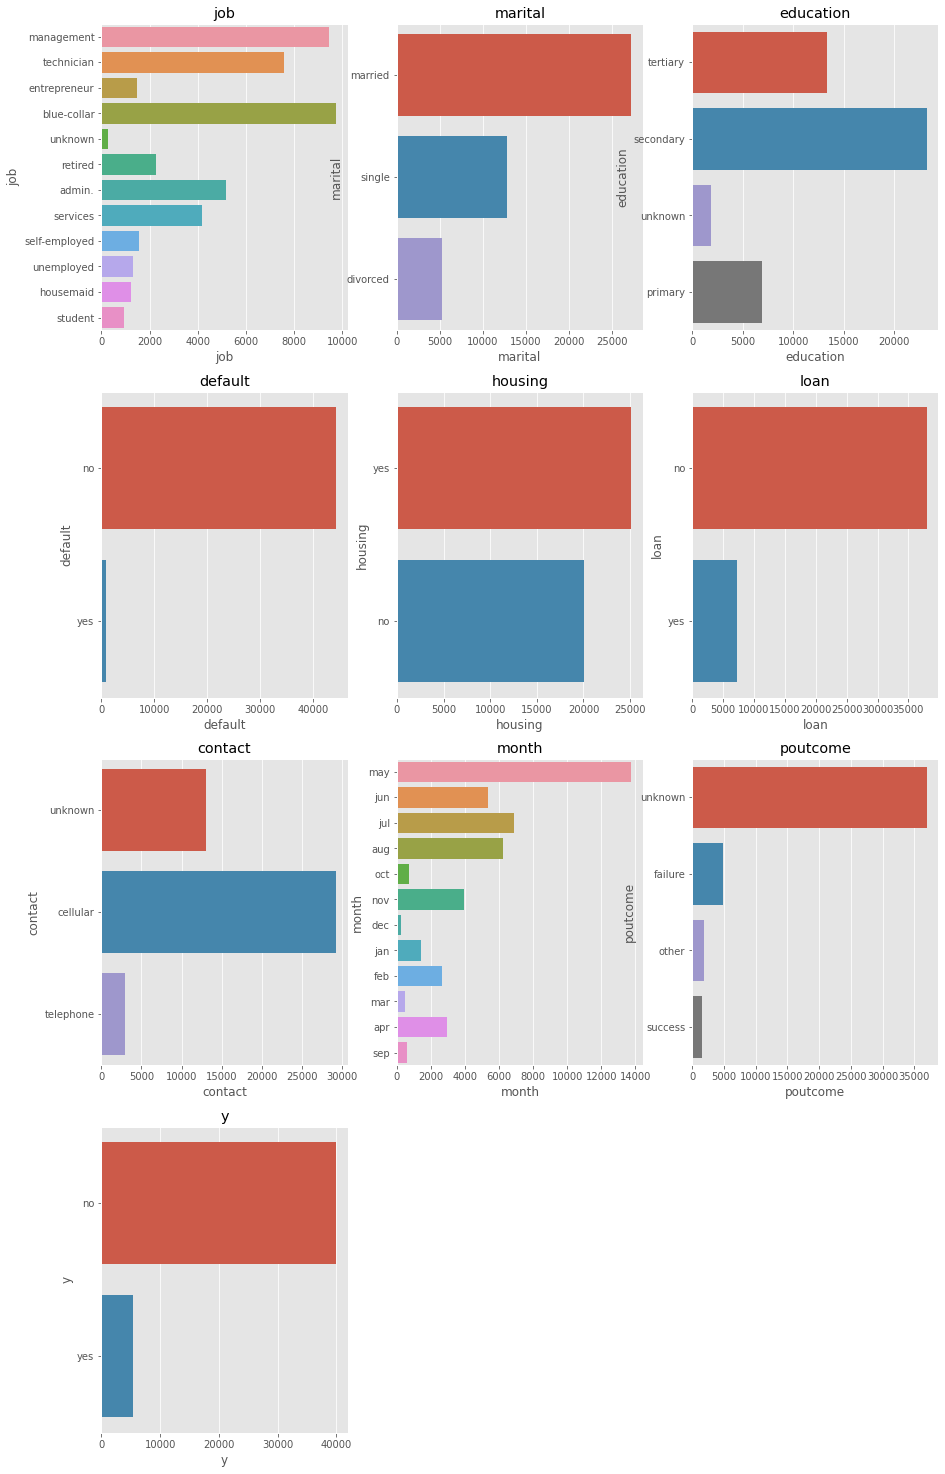

In [13]:
# посмотрю плотности распределения категориальных и бинарных признаков

plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for feature in cat_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=feature,data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber+=1
plt.show()

**Вывод:** Значения по категориям распределены неравномерно. Так среди клиентов, участвующих в маркетинговой компании в большинстве люди с профессией менеджеров или из рабочего класса. Большая часть клиентов женаты, имеют среднее образование и тд. На мой взгляд, интересно, что последний месяц контакта в году - май. Возможно, потому что для многих людей это последний рабочий месяц, а затем у многих начинаются летний отдых и не так охотно отвечают на звонки банков.

### 2.3 Корреляция признаков
Для того, чтобы выявить корреляцию между признаками закодируем котегориальные и бинарные признаки, в том числе отклики.

In [14]:
# Кодируем отклик значениями 0 и 1
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [15]:
label_encoding = {
    "poutcome":{"unknown":0,"failure":1,"other":2,"success":3},
    "month":{"jan":0,"feb":1,"mar":2,"apr":3,"may":4,"jun":5,"jul":6,"aug":7,"sep":8,"oct":9,"nov":10,"dec":11},
    "contact":{"unknown":0,"cellular":1,"telephone":2},
    "loan":{"no":0,"yes":1},
    "housing":{"no":0,"yes":1},
    "default":{"no":0,"yes":1},
    "education":{"tertiary":0,"secondary":1,"unknown":2,"primary":3},
    "marital":{"married":0,"single":1,"divorced":2},   
    "job":{"management":0,"technician":1,"entrepreneur":2,"blue-collar":3,"unknown":4,"retired":5,"admin.":6,"services":7,"self-employed":8,"unemployed":9,"housemaid":10,"student":11}
}

In [16]:
df = df.replace(label_encoding)
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,0,0,0,0,2143,1,0,0,5,4,261,1,-1,0,0,0
1,44,1,1,1,0,29,1,0,0,5,4,151,1,-1,0,0,0
2,33,2,0,1,0,2,1,1,0,5,4,76,1,-1,0,0,0
3,47,3,0,2,0,1506,1,0,0,5,4,92,1,-1,0,0,0
4,33,4,1,2,0,1,0,0,0,5,4,198,1,-1,0,0,0
5,35,0,0,0,0,231,1,0,0,5,4,139,1,-1,0,0,0
6,28,0,1,0,0,447,1,1,0,5,4,217,1,-1,0,0,0
7,42,2,2,0,1,2,1,0,0,5,4,380,1,-1,0,0,0
8,58,5,0,3,0,121,1,0,0,5,4,50,1,-1,0,0,0
9,43,1,1,1,0,593,1,0,0,5,4,55,1,-1,0,0,0


In [17]:
# коррелируют ли данные между собой?

df.corr()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.004262,-0.126351,0.197850,-0.017879,0.097783,-0.185513,-0.015655,0.092577,-0.009120,0.092903,-0.004648,0.004760,-0.023758,0.001288,0.012238,0.025155
job,0.004262,1.000000,0.025000,0.259541,-0.007340,-0.029654,-0.041317,-0.012578,0.001588,-0.027535,-0.064629,0.008166,-0.035410,0.007492,-0.006466,0.014057,0.022396
marital,-0.126351,0.025000,1.000000,-0.109133,0.018404,-0.028172,-0.011671,-0.018526,-0.014290,-0.005217,-0.044321,0.018834,-0.029294,0.020832,0.006876,0.020126,0.043846
education,0.197850,0.259541,-0.109133,1.000000,0.008114,-0.048649,0.044788,0.002191,-0.068756,-0.024666,-0.061310,-0.003267,0.002234,-0.010713,-0.024818,-0.048727,-0.058675
default,-0.017879,-0.007340,0.018404,0.008114,1.000000,-0.066745,-0.006025,0.077234,-0.024095,0.009424,0.014989,-0.010021,0.016822,-0.029979,-0.018329,-0.037940,-0.022419
balance,0.097783,-0.029654,-0.028172,-0.048649,-0.066745,1.000000,-0.068768,-0.084350,0.047701,0.004503,0.094605,0.021560,-0.014578,0.003435,0.016674,0.037272,0.052838
housing,-0.185513,-0.041317,-0.011671,0.044788,-0.006025,-0.068768,1.000000,0.041323,-0.207722,-0.027982,-0.173887,0.005075,-0.023599,0.124178,0.037076,-0.000527,-0.139173
loan,-0.015655,-0.012578,-0.018526,0.002191,0.077234,-0.084350,0.041323,1.000000,0.000058,0.011370,0.021638,-0.012412,0.009980,-0.022754,-0.011043,-0.047586,-0.068185
contact,0.092577,0.001588,-0.014290,-0.068756,-0.024095,0.047701,-0.207722,0.000058,1.000000,0.038643,0.167103,0.001494,0.020046,0.210651,0.139518,0.221644,0.130590
day,-0.009120,-0.027535,-0.005217,-0.024666,0.009424,0.004503,-0.027982,0.011370,0.038643,1.000000,0.101989,-0.030206,0.162490,-0.093044,-0.051710,-0.072629,-0.028348


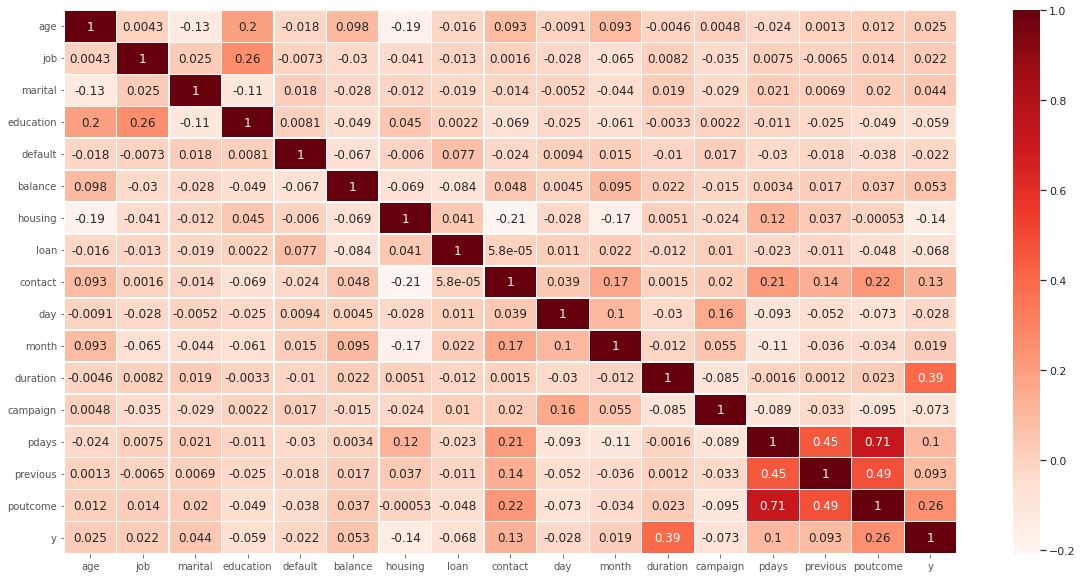

In [18]:
# построю карту корреляций

figure, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df.corr(), cmap='Reds', annot=True, linewidths=0.25)

plt.show()

**Вывод:** 
- 0.71 корреляция между "poutcome" и "pdays". Чем больше дней прошло с момента последнего контакта с клиентом прошлой компании, тем выше вероятность, что прошлая маркетинговая компания была успешной.
- 0.49 корреляция между "poutcome" и "previous". Чем больше было контактов с клиентом в прошлой маркетинговой компании, тем выше вероятность успеха.
- Можно заметить среднюю корреляцию между "pdays" и "previous" в размере 0.45. То есть, чем больше дней прошло с момента последнего контакта, тем больше контактов было совершено. Интерпретируя, если много дней прошло, то все звонки уже совершены и все условия обговорены и звонков больше не предстоит. Так и наоборот, если дней прошло мало, то, вероятно, звонки еще предстоят.

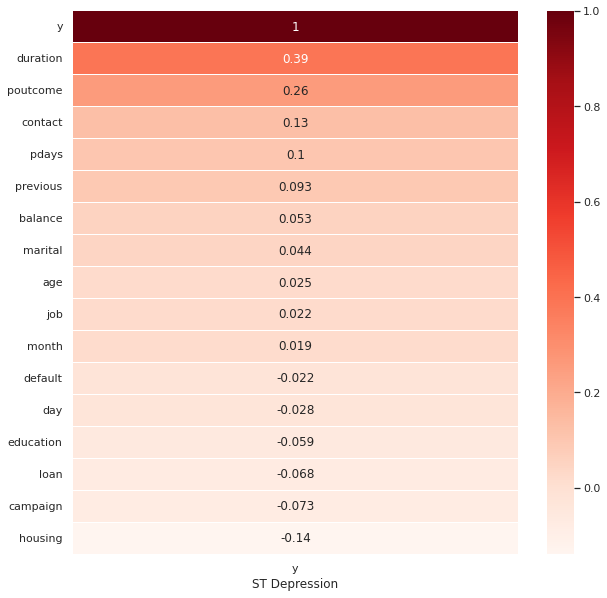

In [19]:
# построю карту корреляций с целевой переменной "y"

figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(
    df.corr()[['y']].sort_values(by='y', ascending=False),
    cmap='Reds',
    annot=True,
    linewidths=0.25
)

ax.set(xlabel='ST Depression')
plt.show()

**Вывод:** Наибольшую корреляцию с целевой переменной имеет признак "duration". Это значит, что вероятность положительный ответ клиента по открытию срочного депозита тем больше, чем больше продолжительность последнего контакта.

## 3. Подготовка данных

In [20]:
# проверю сбалансированность классов

df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

**Вывод:** Классы несбалансированны. Приблизительно 88% откликов относятся к классу "0" и 12% к классу "1". Для борьбы с дисбалансом применю oversampling.

### 3.1 Разделение набора данных

In [21]:
#  разделяю предикоторы и отклики

X = df.iloc[:, :-1].values  
y = df['y']

In [22]:
X

array([[ 58,   0,   0, ...,  -1,   0,   0],
       [ 44,   1,   1, ...,  -1,   0,   0],
       [ 33,   2,   0, ...,  -1,   0,   0],
       ...,
       [ 72,   5,   0, ..., 184,   3,   3],
       [ 57,   3,   0, ...,  -1,   0,   0],
       [ 37,   2,   0, ..., 188,  11,   2]])

In [23]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

### 3.2 Oversampling

В качестве стратегии выберу увеличение количества образцов в классе меньшинства. Генерироваться образцы будут при помощи метода over-sample меньшего класса: the Synthetic Minority Oversampling Technique (SMOTE).

In [24]:
# применю преобразование
X_over, y_over = SMOTE().fit_resample(X, y)

print("Число образцов каждого класса ДО преобразования {}".format(Counter(y)))
print("Число образцов каждого класса ПОСЛЕ преобразования {}".format(Counter(y_over)))

Число образцов каждого класса ДО преобразования Counter({0: 39922, 1: 5289})
Число образцов каждого класса ПОСЛЕ преобразования Counter({0: 39922, 1: 39922})


Разделю данные на обучающую и тестовую выборки при помощи `train_test_split` из sklearn в соотношении 70/30, а значение shuffle оставлю по умолчанию - True, чтобы перемешать данные, так как видно что значения классов распредлены по выборке неравномерно.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state = 42)

### 3.3 Выбор метрик качества

1. **Accuracy** - это метрика, которая характеризует качество модели, агрегированное по всем классам. Это полезно, когда классы для имеют одинаковое значение. В моем случае, это не так, положительный класс - важнее.
2. Для того чтобы узнать долю правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом использую метрику **precision**.
3. Долю правильно найденных положительных объектов среди всех объектов положительного класса покажет метрика **recall**.
<center>
  <img src="https://ml-handbook.ru/chapters/model_evaluation/images/Precisionrecall.png"
height="466" width="995">
  </a>
</center>

## 4. Обучение моделей

### 4.1 DecisionTreeClassifier

In [26]:
#  Задаю начальные параметры модели
#  Инициализирую модель

model = DecisionTreeClassifier(random_state=42,
                               criterion='entropy',
                               # максимальная глубина дерева
                               max_depth=6,
                               # максимальное число конечных узлов (сейчас - без ограничений)
                               max_leaf_nodes=None,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=10,
                               # минимальное число элементов в потомке(может быть долей)
                               min_samples_leaf=8,
                               # минимальное значение уменьшения загрязнения (impurity)
                               min_impurity_decrease=0.001,
                               class_weight=None,
                               min_weight_fraction_leaf=0,
                               splitter='best',
                               max_features = None)

# Обучаю модель

model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6,
                       min_impurity_decrease=0.001, min_samples_leaf=8,
                       min_samples_split=10, min_weight_fraction_leaf=0,
                       random_state=42)

In [27]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [28]:
# построю матрицу ошибок на тестовой выборке

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,9530,2443
1,1178,10803


In [29]:
# Precision и Recall на тестовой выбрке

p_tree = precision_score(y_test, y_pred_test)
r_tree = recall_score(y_test, y_pred_test)
print("Precision:", p_tree*100)
print("Recall:", r_tree*100)

Precision: 81.55669636116563
Recall: 90.16776562891245


In [30]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84     10708
           1       0.90      0.82      0.86     13246

    accuracy                           0.85     23954
   macro avg       0.85      0.85      0.85     23954
weighted avg       0.85      0.85      0.85     23954



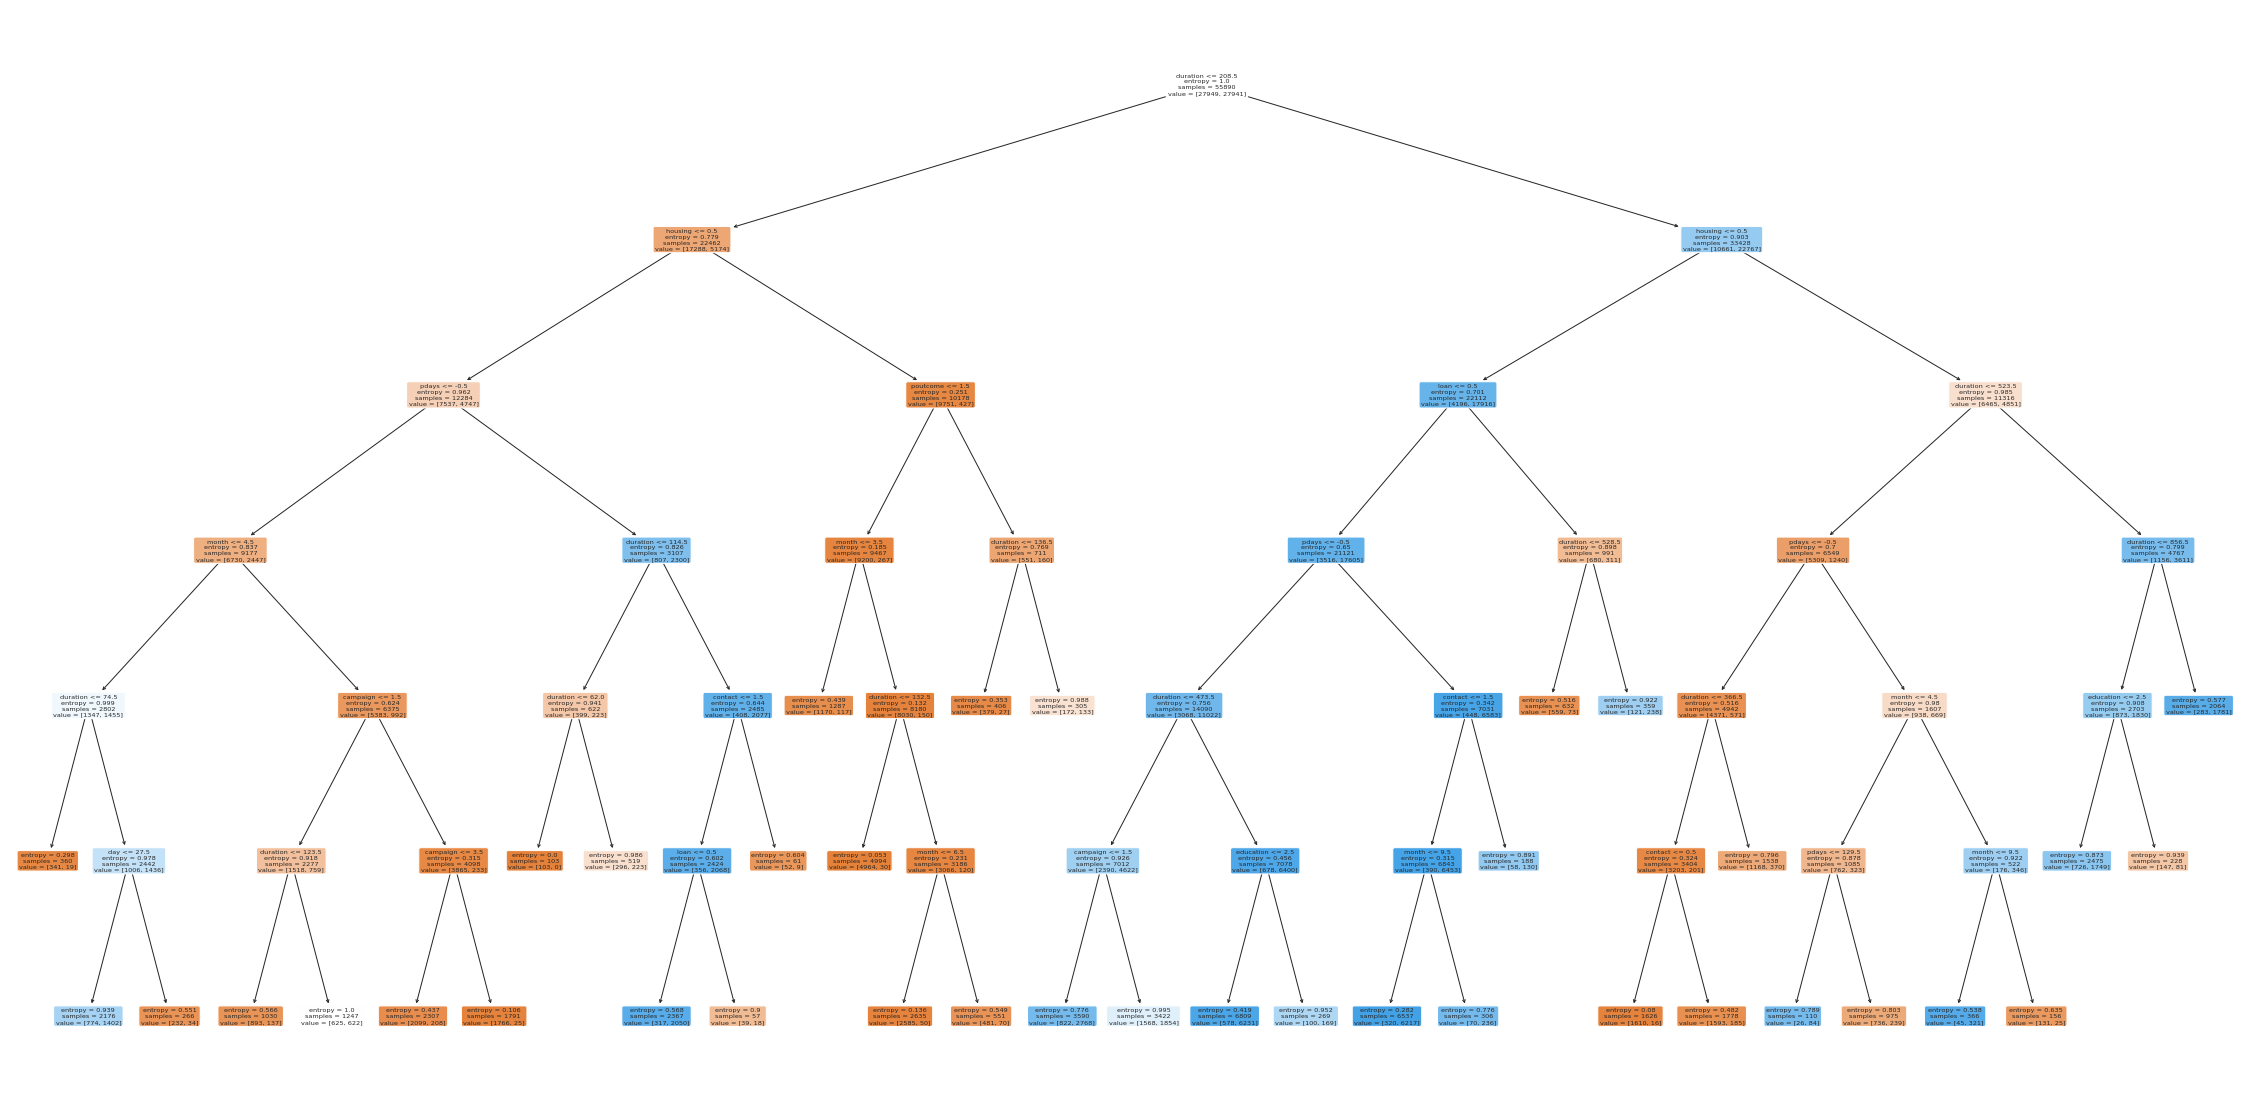

In [31]:
# Построю изображение дерева при помощи sklearn и matplotlib

plt.figure(figsize=(40,20)) 
_ = tree.plot_tree(model, feature_names=df.iloc[:, :-1].columns, filled=True, rounded = True)
plt.show()

In [32]:
# воспользуюсь методом feature_importances_ для оценки ценности каждого параметра данных в таблице

pd.DataFrame({'feature': df.iloc[:, :-1].columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
11,duration,0.498467
6,housing,0.241595
13,pdays,0.101008
10,month,0.054178
12,campaign,0.035813
7,loan,0.034647
8,contact,0.010880
15,poutcome,0.009271
9,day,0.007155
3,education,0.006986


**Вывод:** Оценка ценности парметров указывает на признаки, которые оказывает очень маленькое влияние на модель или не оказывают совсем. Нулевы значения имеют те параметры, корреляция с целевой переменной которых близка к нулю.

Так, на удивление, низкое влияние оказывает возраст, работа, семейное положение, образование, наличие дефолта по кредиту и др.

### 4.2 KNeighborsClassifier

Так как данных много, в качестве параметра числа ближайших соседей возьму 30.

In [33]:
#  Задаю начальные параметры модели
#  Инициализирую модель

classifier = KNeighborsClassifier(n_neighbors=30, 
                                  algorithm='auto',
                                  leaf_size=30,
                                  metric='minkowski',
                                  p=2,
                                  metric_params=None,
                                  n_jobs=1,
                                  weights='uniform')

# обучаю модель

classifier.fit(X_train, y_train) 

KNeighborsClassifier(n_jobs=1, n_neighbors=30)

In [34]:
y_pred_train = classifier.predict(X_train)  
y_pred_test = classifier.predict(X_test)

In [35]:
# построю матрицу ошибок на тестовой выборке

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
conf_mat

,0,1
0,9290,2683
1,1752,10229


In [36]:
# Precision и Recall на тестовой выбрке

p_class = precision_score(y_test, y_pred_test)
r_class = recall_score(y_test, y_pred_test)
print("Precision:", p_class*100)
print("Recall:", r_class*100)

Precision: 79.22087980173482
Recall: 85.37684667390035


In [37]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     11042
           1       0.85      0.79      0.82     12912

    accuracy                           0.81     23954
   macro avg       0.81      0.82      0.81     23954
weighted avg       0.82      0.81      0.82     23954



### 4.3 LogisticRegression

In [38]:
#  Задаю начальные параметры модели
#  Инициализирую модель

logress = LogisticRegression(solver='lbfgs', random_state=42)

# обучаю модель
logress.fit(X_train, y_train) 

LogisticRegression(random_state=42)

In [39]:
y_pred_train = logress.predict(X_train)  
y_pred_test = logress.predict(X_test)

In [40]:
# построю матрицу ошибок на тестовой выборке

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=logress.classes_, columns=logress.classes_)
conf_mat

,0,1
0,9702,2271
1,2368,9613


In [41]:
# Precision и Recall на тестовой выбрке

p_log = precision_score(y_test, y_pred_test)
r_log = recall_score(y_test, y_pred_test)
print("Precision:", p_log*100)
print("Recall:", r_log*100)

Precision: 80.89027263547626
Recall: 80.23537267339955


In [42]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81     12070
           1       0.80      0.81      0.81     11884

    accuracy                           0.81     23954
   macro avg       0.81      0.81      0.81     23954
weighted avg       0.81      0.81      0.81     23954



### 4.4 Сравнение результатов

Построю таблицу и barplot для сравнения точности моделей.

In [43]:
res = pd.DataFrame()
res['Model'] = ['DescisionTree','KNeighborsClassifier','LogisticRegression']
res['Precision'] = [p_tree, p_class, p_log]
res['Recall']=[r_tree, r_class, r_log]
res

,Model,Precision,Recall
0,DescisionTree,0.815567,0.901678
1,KNeighborsClassifier,0.792209,0.853768
2,LogisticRegression,0.808903,0.802354


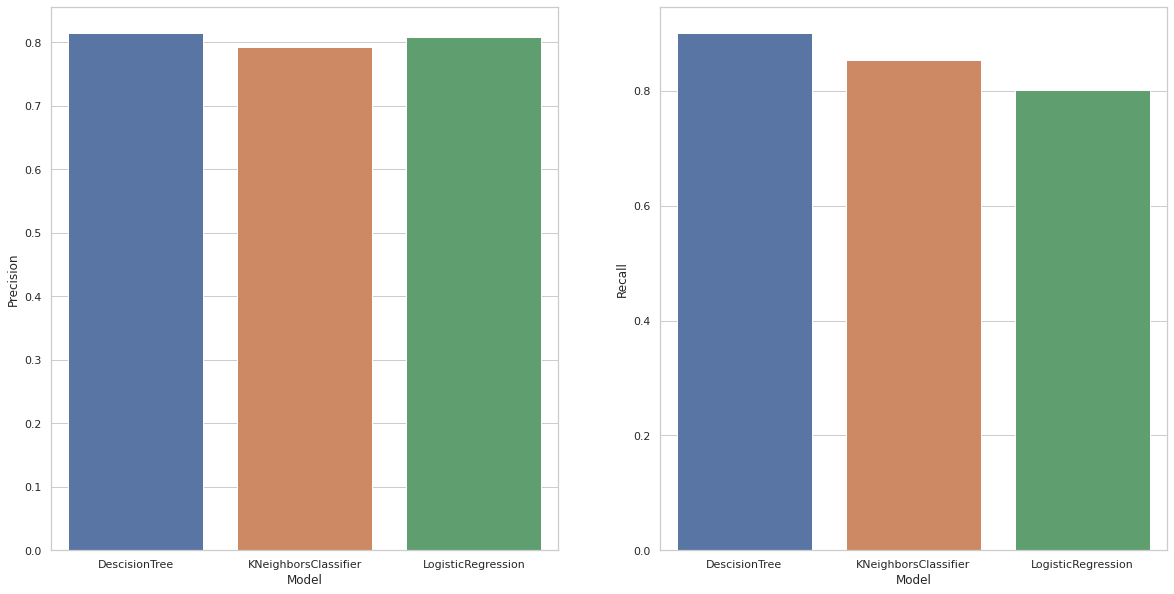

In [44]:
figure, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid')

precision = sns.barplot(ax=ax[0], y ='Precision',x = 'Model',data = res)
precision.set()

recall = sns.barplot(ax=ax[1], y ='Recall',x = 'Model',data = res)
recall.set()

plt.show()

**Вывод:** Самая перспективная модель - DescisionTree. Она имеет наибольший precision и recall.

## 5. Улучшение результата

Для того, чтобы повысить точность сделаю слудующее:
- Отберу признаки. Уберу признаки, которые имеют минимальную или нулевую корреляцию с целевой переменной.
- Стандартизую признаки.
- Применю ансамбль XGBoost для классификации.

### 5.1 Отбор признаков

In [45]:
df_new = df.drop(['marital', 'age', 'job', 'default', 'education'], axis=1)
df_new.head()

,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,2143,1,0,0,5,4,261,1,-1,0,0,0
1,29,1,0,0,5,4,151,1,-1,0,0,0
2,2,1,1,0,5,4,76,1,-1,0,0,0
3,1506,1,0,0,5,4,92,1,-1,0,0,0
4,1,0,0,0,5,4,198,1,-1,0,0,0


In [46]:
X_new = df_new.iloc[:, :-1].values  
y_new = df_new['y']

In [47]:
X_new

array([[2143,    1,    0, ...,   -1,    0,    0],
       [  29,    1,    0, ...,   -1,    0,    0],
       [   2,    1,    1, ...,   -1,    0,    0],
       ...,
       [5715,    0,    0, ...,  184,    3,    3],
       [ 668,    0,    0, ...,   -1,    0,    0],
       [2971,    0,    0, ...,  188,   11,    2]])

In [48]:
y_new

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [49]:
# применю преобразование
X_new_over, y_new_over = SMOTE().fit_resample(X_new, y_new)

print("Число образцов каждого класса ДО преобразования {}".format(Counter(y_new)))
print("Число образцов каждого класса ПОСЛЕ преобразования {}".format(Counter(y_new_over)))

Число образцов каждого класса ДО преобразования Counter({0: 39922, 1: 5289})
Число образцов каждого класса ПОСЛЕ преобразования Counter({0: 39922, 1: 39922})


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_new_over, y_new_over, test_size=0.3, random_state = 42)

### 5.2 Стандратизация признаков

In [51]:
# cтандартизирую признаки

scaler = StandardScaler()   # среднее 0, ст.отклонение 1

scaler.fit(X_train)

X_train_2 = scaler.transform(X_train)  
X_test_2 = scaler.transform(X_test) 

### 5.3 XGBoost

Для повышения точности модели использую ансамблевый метод XGBoost.

In [52]:
# Задаю начальные параметры модели
# Инициализирую модель

XGB = XGBClassifier(base_score=0.5,
                      booster='gbtree',
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      colsample_bytree=0.66,
                      gamma=0,
                      learning_rate=0.01,
                      max_delta_step=0,
                      max_depth=8,
                      min_child_weight=1,
                      missing=1,
                      n_estimators=500,
                      n_jobs=1,
                      nthread=-1,
                      objective='binary:logistic',
                      eval_metric='error',
                      random_state=42,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      seed=1234,
                      subsample=0.66,
                      verbosity=1)

# Обучаю модель

XGB.fit(X_train_2, y_train)

XGBClassifier(colsample_bytree=0.66, eval_metric='error', learning_rate=0.01,
              max_depth=8, missing=1, n_estimators=500, nthread=-1,
              random_state=42, seed=1234, subsample=0.66)

In [53]:
y_pred_train = XGB.predict(X_train_2)  
y_pred_test = XGB.predict(X_test_2)

In [54]:
# построю матрицу ошибок на тестовой выборке

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=XGB.classes_, columns=XGB.classes_)
conf_mat

,0,1
0,10521,1452
1,791,11190


In [55]:
# Precision и Recall на тестовой выбрке

p_xgb = precision_score(y_test, y_pred_test)
r_xgb = recall_score(y_test, y_pred_test)
print("Precision:", p_xgb*100)
print("Recall:", r_xgb*100)

Precision: 88.51447555766492
Recall: 93.39787997662967


In [56]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11312
           1       0.93      0.89      0.91     12642

    accuracy                           0.91     23954
   macro avg       0.91      0.91      0.91     23954
weighted avg       0.91      0.91      0.91     23954



### 5.4 Сравнение результатов

Построю таблицу и barplot для сравнения точности моделей.

In [57]:
res = pd.DataFrame()
res['Model'] = ['XGBoost', 'DescisionTree','KNeighborsClassifier','LogisticRegression']
res['Precision'] = [p_xgb, p_tree, p_class, p_log]
res['Recall']=[r_xgb, r_tree, r_class, r_log]
res

,Model,Precision,Recall
0,XGBoost,0.885145,0.933979
1,DescisionTree,0.815567,0.901678
2,KNeighborsClassifier,0.792209,0.853768
3,LogisticRegression,0.808903,0.802354


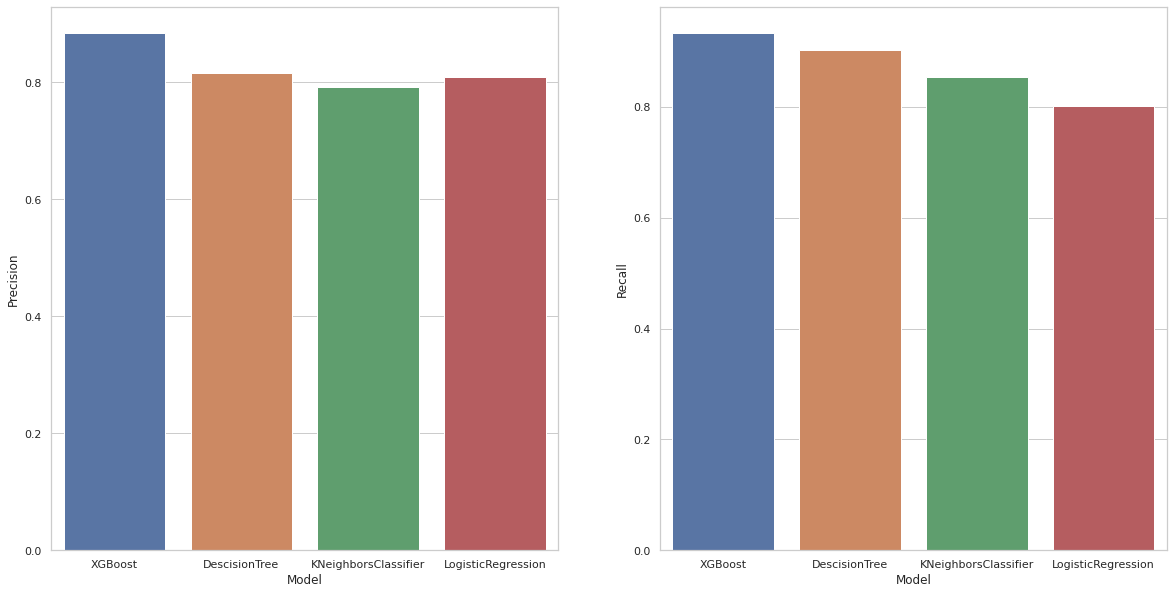

In [58]:
figure, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid')

precision = sns.barplot(ax=ax[0], y ='Precision',x = 'Model',data = res)
precision.set()

recall = sns.barplot(ax=ax[1], y ='Recall',x = 'Model',data = res)
recall.set()

plt.show()

**Вывод:** В результате отбора признаков, стандартизации признаков и применения ансамблирования удалось повысить точность и полноту модели. По сравнению с самой перспективной моделью - DescisionTree удалось повысить точность на ~7% и полноту на ~3%.

## 6. Предсказание
Предсказать класс объекта на модели XGBoost.

In [59]:
# распознаю вероятности принадлежать классам

y_pred_train2 = XGB.predict_proba(X_train)
y_pred_test2 = XGB.predict_proba(X_test)

In [60]:
# функция для стандартизации данных для предсказания

def transform(data):
    new_item = np.array(data).reshape(1, -1)
    new_item_t = scaler.transform(new_item)
    new_item_t = np.reshape(new_item_t, 11)
    return new_item_t

In [61]:
print(' Предсказание класса для 1 объекта: {}'.format(XGB.predict([transform([3200, 0, 0, 1, 3, 4, 230, 3, 40, 1, 3])])),'\n','Вероятности классов для 1 объекта:{}'.format(XGB.predict_proba([transform([3200, 0, 0, 1, 3, 4, 230, 3, 40, 1, 3])])))
print(' Предсказание класса для 2 объекта: {}'.format(XGB.predict([transform([-500, 1, 1, 2, 5, 3, 12, 1, 10, 1, 2])])),'\n','Вероятности классов для 2 объекта:{}'.format(XGB.predict_proba([transform([-500, 1, 1, 2, 5, 3, 12, 1, 10, 1, 2])])))

 Предсказание класса для 1 объекта: [1] 
 Вероятности классов для 1 объекта:[[0.08654851 0.9134515 ]]
 Предсказание класса для 2 объекта: [0] 
 Вероятности классов для 2 объекта:[[0.96779865 0.03220135]]


Так 1 клиент:
- с 3200 евро на счету
- без жилищного и личного кредита
- контакт по сотовому телефону
- контакт был 3 мая
- разговор длился 230 секунд
- уже совершенно 3 контакта в текущей компании
- прошлая компания закончилась успешно, 40 дней назад, был совершен 1 контакт

будет отнесен к **положительному** классу с вероятностью 91%.

2 клиент:
- с минусом на счету
- с жилищным и личным кредитом
- контакт по стационарному телефону
- контакт был 5 апреля
- разговор длился 12 секунд
- уже совершен 1 контакт в текущей компании
- прошлая компания закончилась неудачно, 10 дней назад, был совершен 1 контакт

будет отнесен к **отрицательному** классу с вероятностью 97%.

## Вывод

В результате удалось достигнуть точности в 88% за счет нахождения и удаления из классификации признаков, не оказывающих влияние на целевую переменную, стандартизации данных и ансамблирования модели. Оказалось что возраст, работа, семейное положение, образование имеют низкую ценность в данном наборе, несмотря на их высокую социальную значимость. Самое высокую ценность имеет длительность последнего контакта. Это можно интерпретировать так, чем более клиент открытый к разговору, а сотрудник готовый приводить много доводов, тем вероятнее клиент оформит срочный депозит.

В настоящее время существуют аналогичные методы решения задачи предсказания результатов маркетинговых компаний банка. Среди них:
- алгоритм кластеризации, который итерационно выполняет группировку объектов в кластеры, содержащие аналогичные характеристики и записывает данные в виде набора закономерностей, которые можно исследовать или делать на их основе прогнозы.
- нейросетевые модели, так как они позволяют выявлять нелинейные связи между признаками.


Но особенностью результатов банковских кампаний является несбалансированность классов, так как клиенты чаще отказываются от предложений, чем соглашаются. Поэтому важно использовать способы сбалансировать классы.
Перспективой решения задачи для банка вижу предварительную кластеризацию клиентов и контакты только с клиентами, попавшими в кластер с теми, кто чаще других соглашается на банковские предложения. Это позволит экономить ресурсы, затрачивыемые на каждого клиента и повысить долю успешных контактов.